# Boltzmann Outgoing Longwave Radiation

In this document an Energy Balance Model (EBM) is set up with the Outgoing Longwave Radiation (OLR) parametrized through the Stefan Boltzmann radiation of a grey body. 

$$ OLR(\varphi) = \sigma \cdot \varepsilon \cdot T_s(\varphi)^4$$

In [1]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

### Model Creation

An EBM model instance is created through

In [2]:
# model creation
ebm_boltz = climlab.EBM(D=0.8, Tf=-2)

The model is set up by default with a linearized OLR parametrization (A+BT).

In [3]:
# print model states and suprocesses
print(ebm_boltz)

climlab Process of type <class 'climlab.model.ebm.EBM'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.ebm.EBM'>
   LW: <class 'climlab.radiation.aplusbt.AplusBT'>
   insolation: <class 'climlab.radiation.insolation.P2Insolation'>
   albedo: <class 'climlab.surface.albedo.StepFunctionAlbedo'>
      iceline: <class 'climlab.surface.albedo.Iceline'>
      warm_albedo: <class 'climlab.surface.albedo.P2Albedo'>
      cold_albedo: <class 'climlab.surface.albedo.ConstantAlbedo'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>



### Create new subprocess

The creation of a subprocess needs some information from the model, especially on which model state the subprocess should be defined on.

In [4]:
# create Boltzmann subprocess
LW_boltz = climlab.radiation.Boltzmann(eps=0.65, tau=0.95,
                                       state=ebm_boltz.state,
                                       **ebm_boltz.param)

Note that the model's **whole state dictionary** is given as **input** to the subprocess. In case only the temperature field ``ebm_boltz.state['Ts']`` would be given, a new state dictionary would be created which holds the surface temperature with the key ``'default'``. That raises an error as the Boltzmann process refers the temperature with key ``'Ts'``.

Now the new OLR subprocess has to be merged into the model. Therefore, the `AplusBT` subprocess has to be removed first.

In [5]:
# remove the old longwave subprocess
ebm_boltz.remove_subprocess('LW')

# add the new longwave subprocess
ebm_boltz.add_subprocess('LW',LW_boltz)

Note that the new OLR subprocess has to have the **same key `'LW'`** as the old one, as the model refers to this key for radiation balance computation.

That is why the old process has to be removed before the new one is added.

In [6]:
print(ebm_boltz)

climlab Process of type <class 'climlab.model.ebm.EBM'>. 
State variables and domain shapes: 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.ebm.EBM'>
   insolation: <class 'climlab.radiation.insolation.P2Insolation'>
   albedo: <class 'climlab.surface.albedo.StepFunctionAlbedo'>
      iceline: <class 'climlab.surface.albedo.Iceline'>
      warm_albedo: <class 'climlab.surface.albedo.P2Albedo'>
      cold_albedo: <class 'climlab.surface.albedo.ConstantAlbedo'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   LW: <class 'climlab.radiation.boltzmann.Boltzmann'>



### Model integration & Plotting

To visualize the model state at beginning of integration we first integrate the model only for one timestep:

In [7]:
# integrate model for a single timestep
ebm_boltz.step_forward()

The following code plots the current surface temperature, albedo and energy budget:

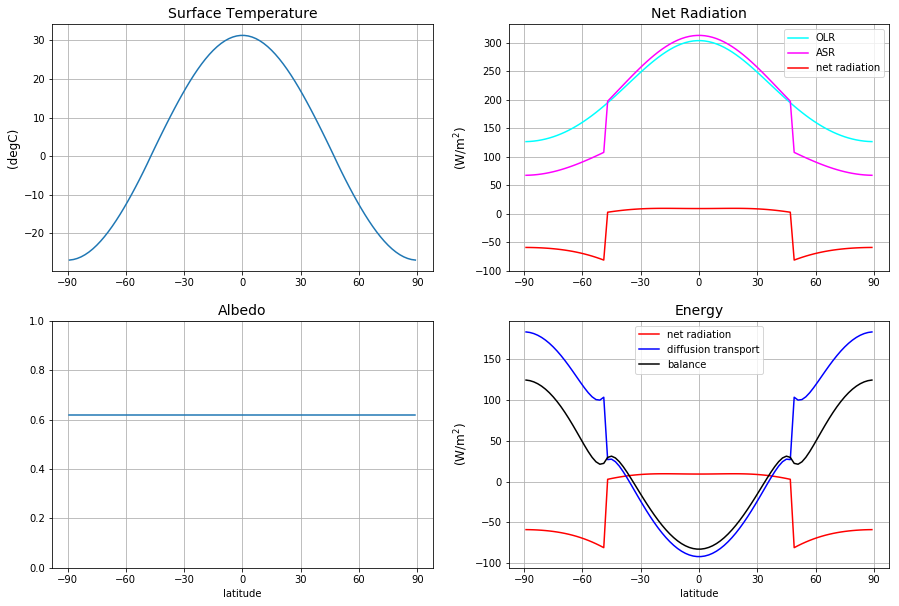

In [8]:
# creating plot figure
fig = plt.figure(figsize=(15,10))

# Temperature plot
ax1 = fig.add_subplot(221)
ax1.plot(ebm_boltz.lat,ebm_boltz.Ts)

ax1.set_xticks([-90,-60,-30,0,30,60,90])
ax1.set_xlim([-90,90])
ax1.set_title('Surface Temperature', fontsize=14)
ax1.set_ylabel('(degC)', fontsize=12)
ax1.grid()

# Albedo plot
ax2 = fig.add_subplot(223, sharex = ax1)
ax2.plot(ebm_boltz.lat,ebm_boltz.albedo)

ax2.set_title('Albedo', fontsize=14)
ax2.set_xlabel('latitude', fontsize=10)
ax2.set_ylim([0,1])
ax2.grid()

# Net Radiation plot
ax3 = fig.add_subplot(222, sharex = ax1)
ax3.plot(ebm_boltz.lat, ebm_boltz.OLR, label='OLR', 
                                       color='cyan')
ax3.plot(ebm_boltz.lat, ebm_boltz.ASR, label='ASR', 
                                       color='magenta')
ax3.plot(ebm_boltz.lat, ebm_boltz.ASR-ebm_boltz.OLR,
                                       label='net radiation',
                                       color='red')

ax3.set_title('Net Radiation', fontsize=14)
ax3.set_ylabel('(W/m$^2$)', fontsize=12)
ax3.legend(loc='best')
ax3.grid()


# Energy Balance plot
net_rad = np.squeeze(ebm_boltz.net_radiation)
transport = ebm_boltz.heat_transport_convergence()

ax4 = fig.add_subplot(224, sharex = ax1)
ax4.plot(ebm_boltz.lat, net_rad, label='net radiation', 
                                 color='red')
ax4.plot(ebm_boltz.lat, transport, label='diffusion transport',
                                   color='blue')
ax4.plot(ebm_boltz.lat, net_rad+transport, label='balance',
                                           color='black')

ax4.set_title('Energy', fontsize=14)
ax4.set_xlabel('latitude', fontsize=10)
ax4.set_ylabel('(W/m$^2$)', fontsize=12)
ax4.legend(loc='best')
ax4.grid()

plt.show()

The two right sided plots show that the model is not in equilibrium. The net radiation reveals that the model currently gains heat and therefore warms up at the poles and loses heat at the equator. From the Energy plot we can see that latitudinal energy balance is not met.

Now we integrate the model as long there are no more changes in the surface temperature and the model reached equilibrium:

In [9]:
# integrate model until solution converges
ebm_boltz.integrate_converge()

Total elapsed time is 7.011111111111103 years.


We run the same code as above to plot the results:

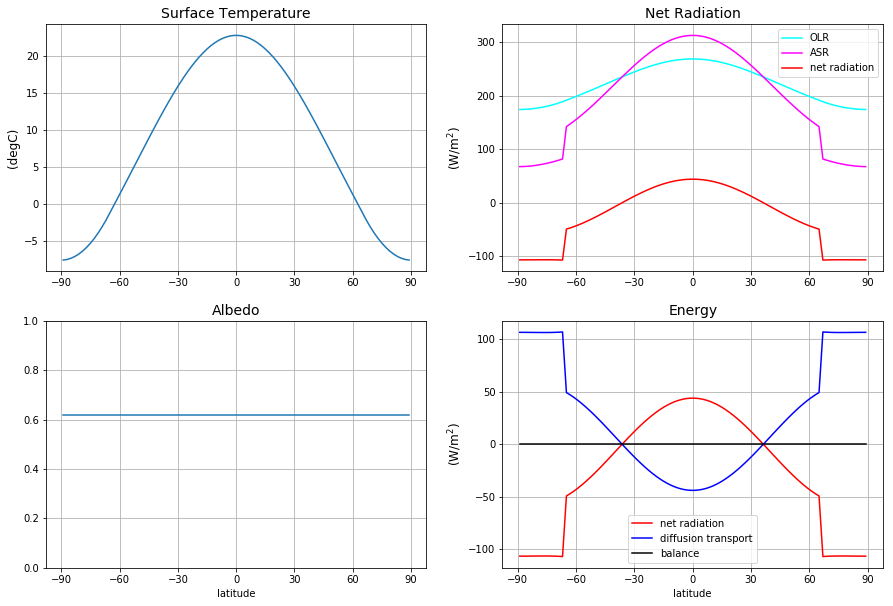

In [10]:
# creating plot figure
fig = plt.figure(figsize=(15,10))

# Temperature plot
ax1 = fig.add_subplot(221)
ax1.plot(ebm_boltz.lat,ebm_boltz.Ts)

ax1.set_xticks([-90,-60,-30,0,30,60,90])
ax1.set_xlim([-90,90])
ax1.set_title('Surface Temperature', fontsize=14)
ax1.set_ylabel('(degC)', fontsize=12)
ax1.grid()

# Albedo plot
ax2 = fig.add_subplot(223, sharex = ax1)
ax2.plot(ebm_boltz.lat,ebm_boltz.albedo)

ax2.set_title('Albedo', fontsize=14)
ax2.set_xlabel('latitude', fontsize=10)
ax2.set_ylim([0,1])
ax2.grid()

# Net Radiation plot
ax3 = fig.add_subplot(222, sharex = ax1)
ax3.plot(ebm_boltz.lat, ebm_boltz.OLR, label='OLR', 
                                       color='cyan')
ax3.plot(ebm_boltz.lat, ebm_boltz.ASR, label='ASR', 
                                       color='magenta')
ax3.plot(ebm_boltz.lat, ebm_boltz.ASR-ebm_boltz.OLR,
                                       label='net radiation',
                                       color='red')

ax3.set_title('Net Radiation', fontsize=14)
ax3.set_ylabel('(W/m$^2$)', fontsize=12)
ax3.legend(loc='best')
ax3.grid()


# Energy Balance plot
net_rad = np.squeeze(ebm_boltz.net_radiation)
transport = ebm_boltz.heat_transport_convergence()

ax4 = fig.add_subplot(224, sharex = ax1)
ax4.plot(ebm_boltz.lat, net_rad, label='net radiation', 
                                 color='red')
ax4.plot(ebm_boltz.lat, transport, label='diffusion transport',
                                   color='blue')
ax4.plot(ebm_boltz.lat, net_rad+transport, label='balance',
                                           color='black')

ax4.set_title('Energy', fontsize=14)
ax4.set_xlabel('latitude', fontsize=10)
ax4.set_ylabel('(W/m$^2$)', fontsize=12)
ax4.legend(loc='best')
ax4.grid()

plt.show()

Now we can see that the latitudinal energy balance is statisfied. Each latitude gains as much heat (net radiation) as is transported out of it (diffusion transport). There is a net radiation surplus in the equator region, so more shortwave radiation is absorbed there than is emitted through longwave radiation. At the poles there is a net radiation deficit. That imbalance is compensated by the diffusive energy transport term.

### Global mean temperature
We use climlab to compute the global mean temperature and print the ice edge latitude:

In [11]:
print('The global mean temperature is %.2f deg C.' %climlab.global_mean(ebm_boltz.Ts))
print('The modeled ice edge is at %.2f deg latitude.' %np.max(ebm_boltz.icelat))

The global mean temperature is 13.33 deg C.
The modeled ice edge is at 66.00 deg latitude.
